# Sentiment for short texts using LSTM: Twitter


IMPORT LIBRARIES

In [3]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 14.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
import string
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
import emoji
nltk.download("punkt")
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from nltk.stem import WordNetLemmatizer
nltk.download("wordnet")
from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from keras.layers import LSTM, Dense, SimpleRNN, Embedding, Flatten, Dropout
from keras.activations import softmax
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


READ FILE

In [5]:
data = pd.read_csv("/content/sentiment_tweets3.csv")
data.head()

,Index,message to examine,label (depression result)
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


RENAME COLUMNS

In [6]:
data.rename(columns = {"message to examine": "Text", "label (depression result)": "Label"}, inplace = True)

data.head()

,Index,Text,Label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat Need to send 'em to my accountant tomo...,0
4,540,ADD ME ON MYSPACE!!! myspace.com/LookThunder,0


DATA SHAPE

In [7]:
data.shape

(10314, 3)

DATA PREPROCESSING

1. change text to lowercase

In [8]:
data["Text"] = data["Text"].str.lower()

data.head()

,Index,Text,Label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat need to send 'em to my accountant tomo...,0
4,540,add me on myspace!!! myspace.com/lookthunder,0


2. Remove HTML Tags

In [9]:
# function to remove HTML Tags from text
def remove_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  return soup.get_text()

  # Remove HTML tags from "Text" column
  data["Text"] = data["Text"].apply(remove_html_tags)

In [10]:
data.head()

,Index,Text,Label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga http://plurk.com/p/mzp1e,0
2,220,@comeagainjen http://twitpic.com/2y2lx - http:...,0
3,288,@lapcat need to send 'em to my accountant tomo...,0
4,540,add me on myspace!!! myspace.com/lookthunder,0


3. Remove URLS

In [16]:
def remove_urls(text):
    url_pattern = r'https?://\S+|www\.\S+|\b[a-z0-9]+\.[a-z]{2,}\S*'
    return re.sub(url_pattern, '', text).strip()

data["Text"] = data["Text"].apply(remove_urls)

In [17]:
data.head()

,Index,Text,Label
0,106,just had a real good moment. i missssssssss hi...,0
1,217,is reading manga,0
2,220,@comeagainjen -,0
3,288,@lapcat need to send 'em to my accountant tomo...,0
4,540,add me on myspace!!!,0


4. Remove punctuations

In [18]:
# Define the punctuation characters to remove
punctuation =  string.punctuation

In [21]:
def clean_text(text):
    # Remove URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Remove Punctuation (Standard + Unicode)
    text = re.sub(r'[^\w\s]', '', text)

    # Remove extra whitespace left behind
    text = " ".join(text.split())

    return text

# Apply function
data["Text"] = data["Text"].apply(clean_text)

In [22]:
data.head()

,Index,Text,Label
0,106,just had a real good moment i missssssssss him...,0
1,217,is reading manga,0
2,220,comeagainjen,0
3,288,lapcat need to send em to my accountant tomorr...,0
4,540,add me on myspace,0


HANDLING ChatWords

In [23]:
# Define a dictionary
chat_words = {
    "AFAIK": "As Far As I Know",
    "AFK": "Away From Keyboard",
    "ASAP": "As Soon As Possible",
    "ATK": "At The Keyboard",
    "ATM": "At The Moment",
    "A3": "Anytime, Anywhere, Anyplace",
    "BAK": "Back At Keyboard",
    "BBL": "Be Back Later",
    "BBS": "Be Back Soon",
    "BFN": "Bye For Now",
    "B4N": "Bye For Now",
    "BRB": "Be Right Back",
    "BRT": "Be Right There",
    "BTW": "By The Way",
    "B4": "Before",
    "B4N": "Bye For Now",
    "CU": "See You",
    "CUL8R": "See You Later",
    "CYA": "See You",
    "FAQ": "Frequently Asked Questions",
    "FC": "Fingers Crossed",
    "FWIW": "For What It's Worth",
    "FYI": "For Your Information",
    "GAL": "Get A Life",
    "GG": "Good Game",
    "GN": "Good Night",
    "GMTA": "Great Minds Think Alike",
    "GR8": "Great!",
    "G9": "Genius",
    "IC": "I See",
    "ICQ": "I Seek you (also a chat program)",
    "ILU": "ILU: I Love You",
    "IMHO": "In My Honest/Humble Opinion",
    "IMO": "In My Opinion",
    "IOW": "In Other Words",
    "IRL": "In Real Life",
    "KISS": "Keep It Simple, Stupid",
    "LDR": "Long Distance Relationship",
    "LMAO": "Laugh My A.. Off",
    "LOL": "Laughing Out Loud",
    "LTNS": "Long Time No See",
    "L8R": "Later",
    "MTE": "My Thoughts Exactly",
    "M8": "Mate",
    "NRN": "No Reply Necessary",
    "OIC": "Oh I See",
    "PITA": "Pain In The A..",
    "PRT": "Party",
    "PRW": "Parents Are Watching",
    "QPSA?": "Que Pasa?",
    "ROFL": "Rolling On The Floor Laughing",
    "ROFLOL": "Rolling On The Floor Laughing Out Loud",
    "ROTFLMAO": "Rolling On The Floor Laughing My A.. Off",
    "SK8": "Skate",
    "STATS": "Your sex and age",
    "ASL": "Age, Sex, Location",
    "THX": "Thank You",
    "TTFN": "Ta-Ta For Now!",
    "TTYL": "Talk To You Later",
    "U": "You",
    "U2": "You Too",
    "U4E": "Yours For Ever",
    "WB": "Welcome Back",
    "WTF": "What The F...",
    "WTG": "Way To Go!",
    "WUF": "Where Are You From?",
    "W8": "Wait...",
    "7K": "Sick:-D Laugher",
    "TFW": "That feeling when",
    "MFW": "My face when",
    "MRW": "My reaction when",
    "IFYP": "I feel your pain",
    "TNTL": "Trying not to laugh",
    "JK": "Just kidding",
    "IDC": "I don't care",
    "ILY": "I love you",
    "IMU": "I miss you",
    "ADIH": "Another day in hell",
    "ZZZ": "Sleeping, bored, tired",
    "WYWH": "Wish you were here",
    "TIME": "Tears in my eyes",
    "BAE": "Before anyone else",
    "FIMH": "Forever in my heart",
    "BSAAW": "Big smile and a wink",
    "BWL": "Bursting with laughter",
    "BFF": "Best friends forever",
    "CSL": "Can't stop laughing"
}

In [25]:
# Function to replace chat words with their full forms
def replace_chat_words(text):
  words = text.split()
  for i, word in enumerate(words):
    if word.lower() in chat_words:
      words[i] = chat_words[word.lower()]
  return " ".join(words)

# Apply replace_chat_words function to "Text" column
data["Text"] = data["Text"].apply(replace_chat_words)

HANDLING STOPWORDS

In [26]:
# Download NLTK stopwords
nltk.download("stopwords")

# Get English stopwords from nltk
stop_words = set(stopwords.words("english"))

# Function to remove stop words from text
def remove_stopwords(text):
  words = text.split()
  filtered_words = [word for word in words if word.lower() not in stop_words]

  # Apply remove_stopwords function to the "Text" column
  data["Text"] = data["Text"].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


HANDLING EMOJIES

In [27]:
# Function to remove emojies from text
def remove_emojis(text):
  return emoji.demojize(text)

# Apply remove_emojis function to "Text" column
data["Text"] = data["Text"].apply(remove_emojis)

LEMMATIZATION

In [36]:
lemmatizer = WordNetLemmatizer()

def word_lemmatize(text):
    # Reduce Lengthening (missssss -> miss)
    text = re.compile(r"(.)\1{2,}").sub(r"\1\1", text)

    # Lemmatize (with space fix)
    words = text.split()
    lemmed = [lemmatizer.lemmatize(w, pos="v") for w in words]

    return " ".join(lemmed)

# Apply to your data
data["Text_lemmatized"] = data["Text"].apply(word_lemmatize)

In [37]:
data.head()

,Index,Text,Label,Text_lemmatized
0,106,just had a real good moment i missssssssss him...,0,just have a real good moment i miss him so much
1,217,is reading manga,0,be read manga
2,220,comeagainjen,0,comeagainjen
3,288,lapcat need to send em to my accountant tomorr...,0,lapcat need to send em to my accountant tomorr...
4,540,add me on myspace,0,add me on myspace


Train Test Split

In [38]:
x = data["Text"]
y = data["Label"]

# Train Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

Tokenization and Padding Sequences

In [39]:
tokenizer = Tokenizer(oov_token = "npthing")
tokenizer.fit_on_texts(x_train)
tokenizer.fit_on_texts(x_test)

In [40]:
tokenizer.document_count

10314

In [44]:
x_train_sequences = tokenizer.texts_to_sequences(x_train)

x_test_sequences = tokenizer.texts_to_sequences(x_test)

In [45]:
maxlen = max(len(tokens) for tokens in x_train_sequences)

print("Maximum sequence length (maxlen):", maxlen)

Maximum sequence length (maxlen): 100


In [47]:
# Perform padding on X_train and X_test sequences
X_train_padded = pad_sequences(x_train_sequences, maxlen=maxlen, padding='post')
X_test_padded = pad_sequences(x_test_sequences, maxlen=maxlen, padding='post')

In [48]:
# Print the padded sequences for X_train and X_test
print("X_train_padded:")
print(X_train_padded)
print("\nX_test_padded:")
print(X_test_padded)

X_train_padded:
[[   46     2    69 ...     0     0     0]
 [   55     3  4290 ...     0     0     0]
 [ 6581  6582    19 ...     0     0     0]
 ...
 [19089     9  1064 ...     0     0     0]
 [  510    12  2012 ...     0     0     0]
 [  528     3    54 ...     0     0     0]]

X_test_padded:
[[19090   457    23 ...     0     0     0]
 [19091     7   828 ...     0     0     0]
 [19092     2   164 ...     0     0     0]
 ...
 [22199  5180 22200 ...     0     0     0]
 [22202     2   745 ...     0     0     0]
 [ 1902  4501   751 ...     0     0     0]]


Input Size

In [49]:
# Embedding Input Size / Vocabulary Size
input_Size = np.max(X_train_padded) + 1
input_Size

np.int32(19090)

Model Building

In [50]:
# Define the model
model = Sequential()

# Use LSTM instead of SimpleRNN for better capturing long-term dependencies
model.add(LSTM(128, input_shape=(75,1), return_sequences=True))

# Add dropout regularization
model.add(Dropout(0.5))

# Add another LSTM layer
model.add(LSTM(128))

# Add dropout regularization
model.add(Dropout(0.5))

# Add a dense layer with ReLU activation
model.add(Dense(64, activation='relu'))

# Output layer with sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

Compile The Model

In [51]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 75, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 206,465 (806.50 KB)

 Trainable params: 206,465 (806.50 KB)

 Non-trainable params: 0 (0.00 B)

Model Training

In [52]:
# Model Train
history = model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_data=(X_test_padded, y_test))

Epoch 1/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 75s 274ms/step - accuracy: 0.7994 - loss: 0.5030 - val_accuracy: 0.8100 - val_loss: 0.4723
Epoch 2/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 82s 276ms/step - accuracy: 0.8200 - loss: 0.4595 - val_accuracy: 0.8318 - val_loss: 0.4348
Epoch 3/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 68s 265ms/step - accuracy: 0.8335 - loss: 0.4414 - val_accuracy: 0.8240 - val_loss: 0.4546
Epoch 4/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 70s 270ms/step - accuracy: 0.8379 - loss: 0.4306 - val_accuracy: 0.8497 - val_loss: 0.4126
Epoch 5/5
258/258 ━━━━━━━━━━━━━━━━━━━━ 83s 275ms/step - accuracy: 0.8476 - loss: 0.4137 - val_accuracy: 0.8502 - val_loss: 0.4114


Plotting The Loss And Accuracy

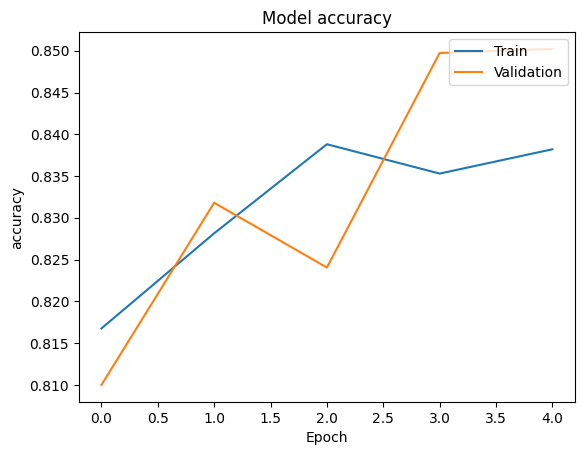

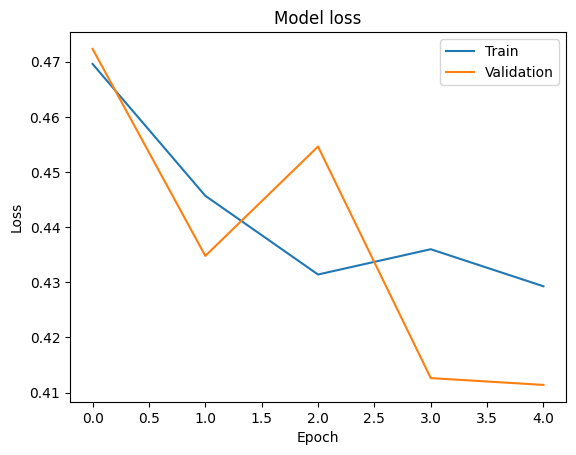

In [53]:
# Plotting the training and testing accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plotting the training and testing loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()